# The Laplace Problem

In [1]:
%reset -f

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

import numpy as np
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')           ## CPU is faster here !

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks',
        font='sans-serif', font_scale=1, color_codes=True, rc={"lines.linewidth": 2})

from updec.cloud import SquareCloud, GmshCloud
from updec.operators import *
from updec.utils import print_line_by_line, polyharmonic, multiquadric

## Using Updec

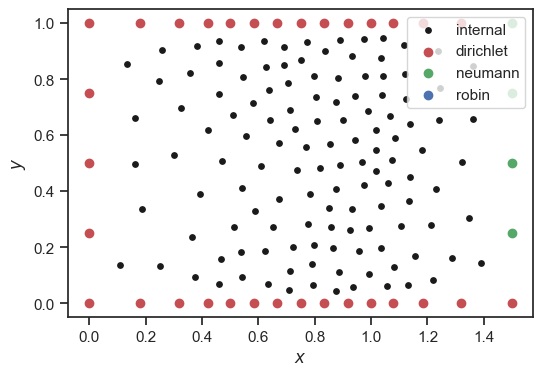

In [9]:
# facet_types = {"south":"d", "west":"d", "north":"d", "east":"d"}
# facet_types = {"Dirichlet":"d", "Robin":"d", "Neumann":"d"}
facet_types = {"inlet":"d", "wall":"d", "blowing":"d", "outlet":"n", "suction":"d"}

# cloud = SquareCloud(Nx=7, Ny=5, facet_types=facet_types, support_size=3)
# cloud = GmshCloud("./meshes/triangle.msh", facet_types, support_size=3)
cloud = GmshCloud("./meshes/channel.msh", facet_types, support_size=3)

cloud.visualize_cloud(figsize=(6,4));

In [ ]:
RBF = polyharmonic      ## Can define which rbf to use
MAX_DEGREE = 2

In [ ]:
## Operates on radial basis functions and polynomials at position x: don't forget the None. It is important!
# @jax.jit
# @partial(jax.jit, static_argnums=2)
def my_diff_operator(x, node=None, monomial=None, *args):
    return  args[0] * nodal_laplacian(x, node, monomial, rbf=RBF) / args[1]

minus_ones = -jnp.ones((cloud.N,))
ones = jnp.ones((cloud.N,))
## Operates on entire fields at position x (inside node)
# @jax.jit
def my_rhs_operator(x):
    # return divergence(x, known_field, cloud, rbf=RBF, max_degree=2)
    # return 2.0
    return 1.0

# d_func = lambda node: 1.0
# n_func = lambda node: 1.0

d_north = lambda node: jnp.sin(jnp.pi * node[0])
d_zero = lambda node: 0.0

boundary_conditions = {0:d_zero, 1:d_zero, 2:d_zero, 3:d_zero}
# boundary_conditions = {"inlet":d_north, "wall":d_zero, "blowing":d_zero, "outlet":d_zero, "suction":d_zero}

# solution_field = pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE, minus_ones, ones)
# cloud.visualize_field(solution_field, cmap="viridis", projection="2d", ax=None, figsize=(6,5));

In [ ]:
u = jnp.ones((cloud.N,))
v = jnp.ones((cloud.N,))
p = jnp.ones((cloud.N,))
RHO = 1
NU = 1

def diff_operator_u(x, node=None, monomial=None, *args):
    u_val = nodal_value(x, node, monomial, rbf=RBF)
    grad_u = nodal_gradient(x, node, monomial, rbf=RBF)
    return  u_val * grad_u[0] + args[0]*grad_u[1]

def rhs_operator_u(x):
    grad_p = gradient(x, p, cloud, rbf=RBF, max_degree=MAX_DEGREE)
    lap_u = laplacian(x, u, cloud, rbf=RBF, max_degree=MAX_DEGREE)
    return  (-grad_p[0] / RHO) + (NU * lap_u)

u = pde_solver(diff_operator_u, rhs_operator_u, cloud, boundary_conditions, RBF, MAX_DEGREE, v)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\rouss\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\rouss\AppData\Local\Temp\ipykernel_23232\1857410623.py", line 17, in <module>
    u = pde_solver(diff_operator_u, rhs_operator_u, cloud, boundary_conditions, RBF, MAX_DEGREE, v)
  File "c:\users\rouss\projects\updec\updec\operators.py", line 138, in pde_solver
  File "c:\users\rouss\projects\updec\updec\assembly.py", line 151, in assemble_q
    q = q.at[i].set(operator(cloud.nodes[i]))
  File "c:\Users\rouss\miniconda3\envs\tf\lib\site-packages\jax\_src\traceback_util.py", line 162, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
  File "c:\Users\rouss\miniconda3\envs\tf\lib\site-packages\jax\_src\api.py", line 522, in cache_miss
    out_flat = xla.xla_call(
  File "c:\Users\rouss\miniconda3\envs\tf\lib\site-packages\jax\core.py", line 1836, in bi

In [ ]:
def diff_operator_v(x, node=None, monomial=None, *args):
    val_v = nodal_value(x, node, monomial, rbf=RBF)
    grad_v = nodal_gradient(x, node, monomial, rbf=RBF)
    return  val_v * grad_v[1] + args[0]*grad_v[0]

def rhs_operator_v(x):
    grad_p = gradient(x, p, cloud, rbf=RBF, max_degree=MAX_DEGREE)
    lap_v = laplacian(x, v, cloud, rbf=RBF, max_degree=MAX_DEGREE)
    return  (-grad_p[0] / RHO) + (NU * lap_v)

v = pde_solver(diff_operator_v, rhs_operator_v, cloud, boundary_conditions, RBF, MAX_DEGREE, u)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\rouss\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\rouss\AppData\Local\Temp\ipykernel_23232\2375313411.py", line 11, in <module>
    v = pde_solver(diff_operator_v, rhs_operator_v, cloud, boundary_conditions, RBF, MAX_DEGREE, u)
  File "c:\users\rouss\projects\updec\updec\operators.py", line 138, in pde_solver
  File "c:\users\rouss\projects\updec\updec\assembly.py", line 151, in assemble_q
    q = q.at[i].set(operator(cloud.nodes[i]))
  File "c:\Users\rouss\miniconda3\envs\tf\lib\site-packages\jax\_src\traceback_util.py", line 162, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
  File "c:\Users\rouss\miniconda3\envs\tf\lib\site-packages\jax\_src\api.py", line 522, in cache_miss
    out_flat = xla.xla_call(
  File "c:\Users\rouss\miniconda3\envs\tf\lib\site-packages\jax\core.py", line 1836, in bi

In [ ]:
def diff_operator_p(x, node=None, monomial=None, *args):
    return  nodal_laplacian(x, node, monomial, rbf=RBF)

def rhs_operator_p(x):
    grad_u = gradient(x, u, cloud, rbf=RBF, max_degree=MAX_DEGREE)
    grad_v = gradient(x, v, cloud, rbf=RBF, max_degree=MAX_DEGREE)
    return  -RHO * (grad_u[0]*grad_u[0] + 2*grad_u[1]*grad_v[0] + grad_v[1]*grad_v[1])

p = pde_solver(diff_operator_p, rhs_operator_p, cloud, boundary_conditions, RBF, MAX_DEGREE)

: 

: 

In [ ]:
u

DeviceArray([ 3.43987267e-05,  5.02347029e-05,  1.77235852e-05,
              4.21552286e-05,  7.25919963e-05,  1.02212027e-04,
              4.84139127e-05,  7.90406048e-05,  3.12962038e-05,
              4.59972325e-05,  7.88823963e-05,  1.10663168e-04,
              5.11429571e-05,  4.93236039e-05,  1.64158282e-05,
             -3.39346928e-09, -5.96568850e-10,  7.02823855e-10,
             -1.12327626e-10, -1.49707047e-09, -2.02795847e-09,
             -8.47910242e-10,  1.36489797e-09, -4.19683788e-10,
             -5.40400558e-10,  3.88464511e-10,  3.60169394e-10,
              3.32175981e-10,  4.27257269e-13, -8.30774546e-11,
              6.05548806e-11, -1.14289515e-10, -1.28116309e-10,
             -8.39520554e-12, -2.75494488e-11], dtype=float32)

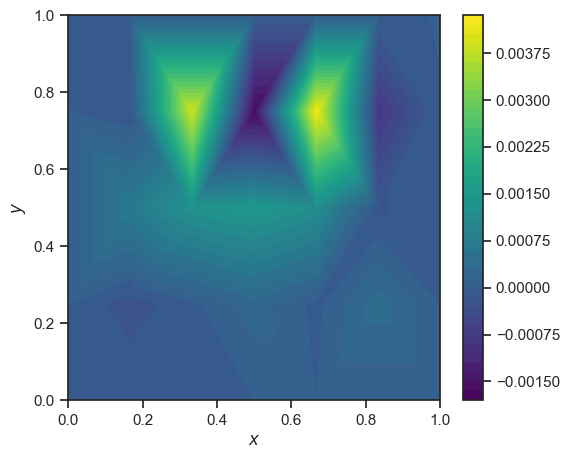

In [ ]:
cloud.visualize_field(v, cmap="viridis", projection="2d", ax=None, figsize=(6,5));